In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge

from sklearn.dummy import DummyRegressor

In [122]:
data = pd.read_csv('data_test_2.csv')
display(data.head())
data.info()

,platform,campaign_id,campaign_name,date,impressions,clicks,drug_name,auditory,databse,adv_way
0,yandex direct,81657672,"ВА027 | Биннофарм_Венарус, Дексонал | Хирурги ...",12/22/2022,7,0,"Венарус, Дексонал",Хирурги,NaN,Баннер на памятку
1,yandex direct,84389757,"ВА036 | Венарус, Венапрокт | Хирурги, проктоло...",4/23/2023,4061,29,"Венарус, Венапрокт","Хирурги, проктологи, колопроктологи",Breffi,Баннеры
2,yandex direct,84390401,"ВА036 | Венарус, Венапрокт | Сосудистые хирург...",4/23/2023,103,2,"Венарус, Венапрокт","Сосудистые хирурги, флебологи",Breffi,Баннеры
3,yandex direct,82546598,"ВА036 | Венарус, Венапрокт | Хирурги, проктоло...",2/16/2023,3621,18,"Венарус, Венапрокт","Хирурги, проктологи, колопроктологи",Breffi,Баннеры
4,yandex direct,88167803,"ВА036 | Венарус, Венапрокт | Баннеры gif | Хир...",6/4/2023,606,12,"Венарус, Венапрокт","Хирурги, проктологи, колопроктологи",Breffi,Баннеры gif


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545 entries, 0 to 4544
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   platform       4545 non-null   object
 1   campaign_id    4545 non-null   int64 
 2   campaign_name  4545 non-null   object
 3   date           4545 non-null   object
 4   impressions    4545 non-null   int64 
 5   clicks         4545 non-null   int64 
 6   drug_name      4545 non-null   object
 7   auditory       4545 non-null   object
 8   databse        3777 non-null   object
 9   adv_way        3627 non-null   object
dtypes: int64(3), object(7)
memory usage: 355.2+ KB


In [123]:
data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y')

In [124]:
data = data.sort_values(by='date', ascending=True)

Проверим набор данных на наличие пропусков

In [125]:
data.isnull().sum()

platform           0
campaign_id        0
campaign_name      0
date               0
impressions        0
clicks             0
drug_name          0
auditory           0
databse          768
adv_way          918
dtype: int64

In [6]:
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['dayofweek'] = data['date'].dt.dayofweek

In [7]:
data = data.fillna('unknown')

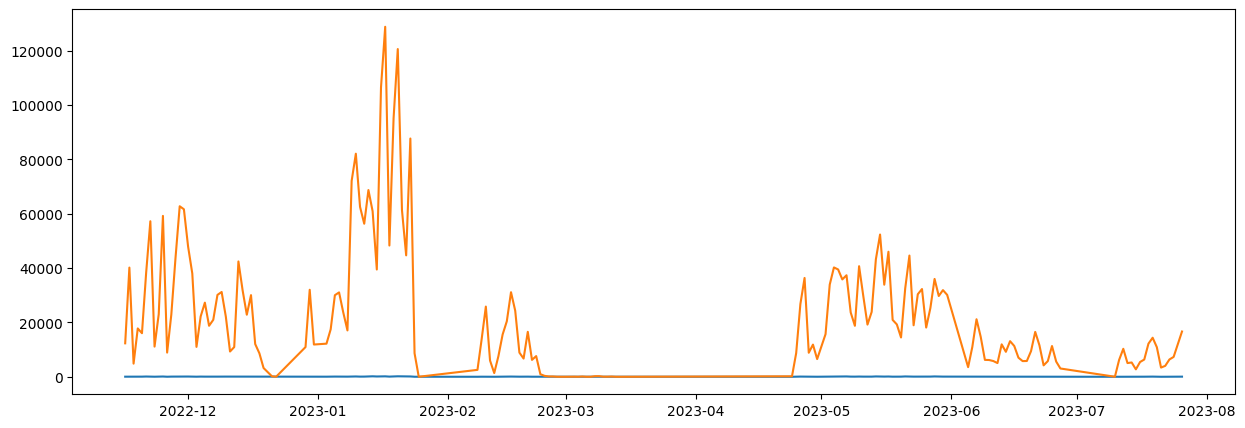

In [8]:
data_80603153 = data[data['campaign_id']==80603153]
data_80603153 = data_80603153.sort_values(by='date', ascending=False)
plt.figure(figsize=(15, 5))
plt.plot(data_80603153['date'],data_80603153['clicks'])
plt.plot(data_80603153['date'],data_80603153['impressions'])
plt.show()

In [128]:
data.date.min()

Timestamp('2022-06-15 00:00:00')

In [129]:
data.date.max()

Timestamp('2023-07-26 00:00:00')

In [130]:
data.date.max() - data.date.min()

Timedelta('406 days 00:00:00')

In [126]:
data.campaign_id.nunique()

111

In [127]:
data.auditory.nunique()

8

In [12]:
table_sum_ctr = pd.pivot_table(data, values=['date', 'impressions', 'clicks'], index=['campaign_id'],
                       aggfunc={'date':[min, max], 'impressions':[sum], 'clicks':[sum]})
display(table_sum_ctr.head())

clicks       date            impressions
               sum        max        min         sum
campaign_id                                         
75218950       949 2023-01-17 2022-06-15      532765
75220599       793 2022-11-15 2022-06-15      569918
75645141       185 2022-11-30 2022-06-24      120402
75993195     12953 2023-07-25 2022-07-08     5420223
76108892      1266 2022-08-27 2022-07-14      461816

In [13]:
sum_ctr = pd.DataFrame(table_sum_ctr['clicks']['sum']/table_sum_ctr['impressions']['sum'])
sum_ctr.fillna(0)
sum_ctr.sort_values(by='sum', ascending=False).head(10)

,sum
campaign_id,
87302599,0.016079
86931353,0.014715
89013463,0.013007
89013407,0.012164
89644586,0.011679
86931208,0.011356
86809161,0.011307
87302401,0.011236
89013504,0.010816


Проверим набор данных на наличие аномальных значений

In [14]:
data.query('impressions == 0 & clicks != 0')

,platform,campaign_id,campaign_name,date,impressions,clicks,drug_name,auditory,databse,adv_way,month,day,dayofweek
46,yandex direct,88167803,"ВА036 | Венарус, Венапрокт | Баннеры gif | Хир...",2023-06-15,0,1,"Венарус, Венапрокт","Хирурги, проктологи, колопроктологи",Breffi,Баннеры gif,6,15,3


Видимо, есть дни, в котрые рекламные кампании были приостановлены

In [15]:
data.query('impressions == 0').shape

(1, 13)

Выделим отдельно данные с ненулевыми показами в набор данных df_adv

In [16]:
df_adv = data.query('impressions != 0').copy()

In [17]:
df_adv['daily_ctr'] = df_adv['clicks']/df_adv['impressions']
df_adv.head()

,platform,campaign_id,campaign_name,date,impressions,clicks,drug_name,auditory,databse,adv_way,month,day,dayofweek,daily_ctr
857,yandex direct,89644586,СВ002 | Неврологи | Баннеры | База Breffi,2023-07-26,2797,31,СВ002,Неврологи,Breffi,Баннеры,7,26,2,0.011083
823,yandex direct,90990136,СВ001 | Гастро | Баннеры gif | База Breffi,2023-07-26,343,4,Необутин,Гастро,Breffi,Баннеры gif,7,26,2,0.011662
4320,yandex direct,79820654,Дексонал | Фармацевты | Баннеры | База Брефи,2023-07-26,15596,119,Дексонал,Фармацевты,Breffi,Баннеры,7,26,2,0.007630
4321,yandex direct,80285056,Дексонал | Терапевты | Баннеры | База Брефи,2023-07-26,4291,16,Дексонал,Терапевты,Breffi,Баннеры,7,26,2,0.003729
4322,yandex direct,80603153,Диклофенак-Акос | Фармацевты | Баннеры | База ...,2023-07-26,16662,46,Диклофенак-Акос,Фармацевты,БФГ,Баннеры,7,26,2,0.002761


In [18]:
df_adv.shape

(4544, 14)

In [19]:
df_adv.duplicated().sum()

0

In [20]:
df_adv.drug_name.unique()

array(['СВ002', 'Необутин', 'Дексонал', 'Диклофенак-Акос', 'Венарус',
       'Венарус_гель', 'Венарус, Венапрокт', 'Максилак',
       'Необутин, Максилак', 'Эльмуцин ', 'Акнауцер', 'Кагоцел, Эльмуцин',
       'Кагоцел ', 'Кагоцел, Кипферон ', 'Венарус, Дексонал ',
       'Парацитолгин ', 'Ангиорус ', 'Дексонал, Диклофенак-АКОС'],
      dtype=object)

In [21]:
df_adv.drug_name.nunique()

18

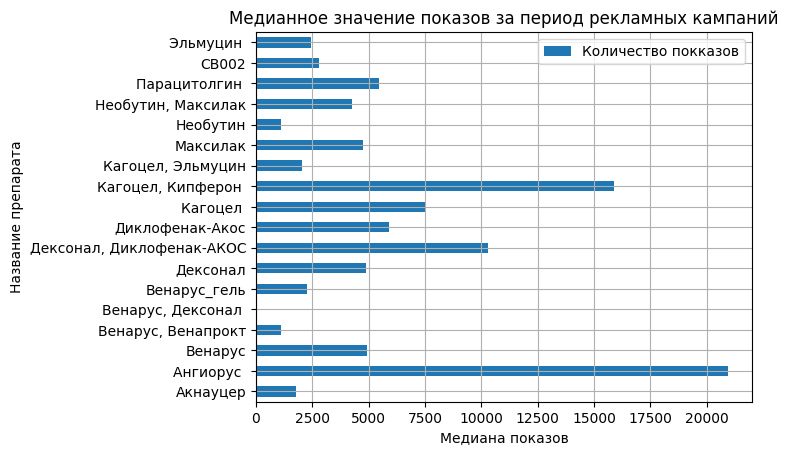

In [22]:
pd.pivot_table(
    df_adv,
    values='impressions',
    index='drug_name',
    aggfunc=['median'],
    sort=True
).plot(kind='barh', grid=True)
plt.title('Медианное значение показов за период рекламных кампаний')
plt.xlabel('Медиана показов')
plt.ylabel('Название препарата')
plt.legend(['Количество покказов'])
plt.show()

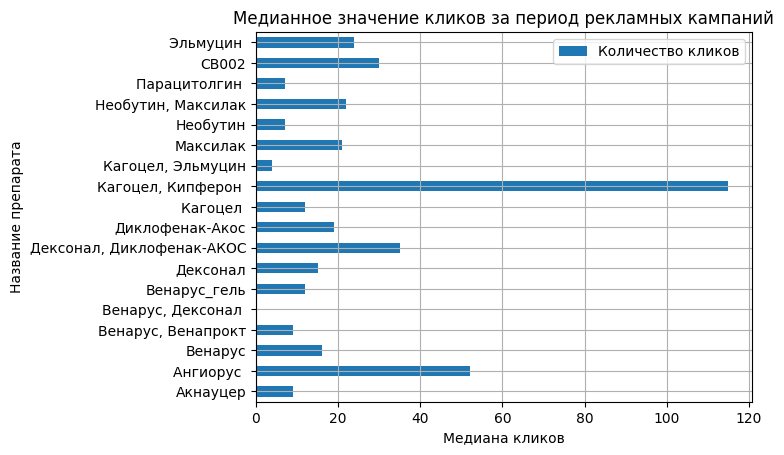

In [23]:
pd.pivot_table(
    df_adv,
    values='clicks',
    index='drug_name',
    aggfunc=['median'],
    sort=True
).plot(kind='barh', grid=True)
plt.title('Медианное значение кликов за период рекламных кампаний')
plt.xlabel('Медиана кликов')
plt.ylabel('Название препарата')
plt.legend(['Количество кликов'])
plt.show()

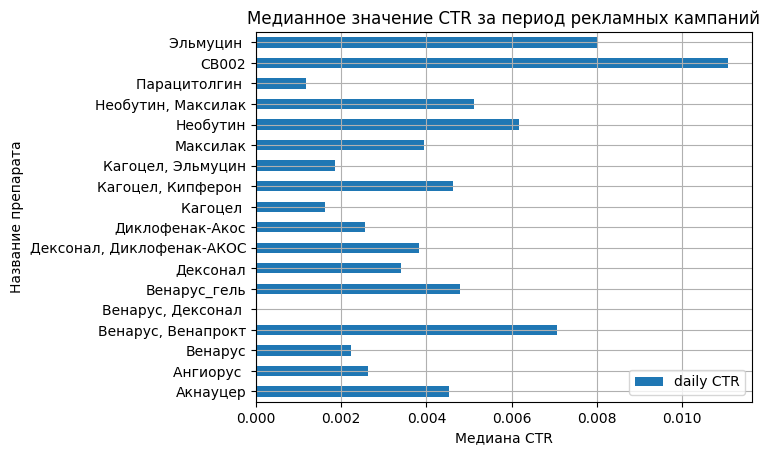

In [24]:
pd.pivot_table(
    df_adv,
    values='daily_ctr',
    index='drug_name',
    aggfunc=['median'],
    sort=True
).plot(kind='barh', grid=True)
plt.title('Медианное значение CTR за период рекламных кампаний')
plt.xlabel('Медиана CTR')
plt.ylabel('Название препарата')
plt.legend(['daily CTR'])
plt.show()

In [25]:
table_sum_ctr = pd.pivot_table(df_adv, values=['date', 'impressions', 'clicks'], index=['drug_name'],
                       aggfunc={'date':[min, max], 'impressions':[sum], 'clicks':[sum]})
display(table_sum_ctr)

clicks       date            impressions
                             sum        max        min         sum
drug_name                                                         
Акнауцер                     228 2023-05-23 2023-04-19       35171
Ангиорус                    1266 2022-08-27 2022-07-14      461816
Венарус                    20010 2023-07-26 2022-06-24     8325197
Венарус, Венапрокт          2965 2023-07-26 2023-01-26      426759
Венарус, Дексонал              0 2022-12-22 2022-12-22           7
Венарус_гель                1368 2023-07-26 2023-07-11      270232
Дексонал                   46834 2023-07-26 2022-06-15    10538322
Дексонал, Диклофенак-АКОС    504 2022-07-31 2022-07-11      125322
Диклофенак-Акос            22135 2023-07-26 2022-06-15     8344314
Кагоцел                     3504 2023-03-19 2022-10-20     2037415
Кагоцел, Кипферон           3598 2023-01-28 2023-01-03      713579
Кагоцел, Эльмуцин           1881 2023-03-31 2022-11-16      824371
Максилак                    7026 2023-07-11 2023-02-21     1727268
Необутин                    6045 2023-07-26 2022-08-24      874882
Необутин, Максилак          2108 2023-07-11 2023-05-02      424501
Парацитолгин                 344 2022-12-06 2022-10-19      256172
СВ002                        827 2023-07-26 2023-06-16       70809
Эльмуцин                    4692 2023-06-09 2023-02-22      669422

<Axes: >

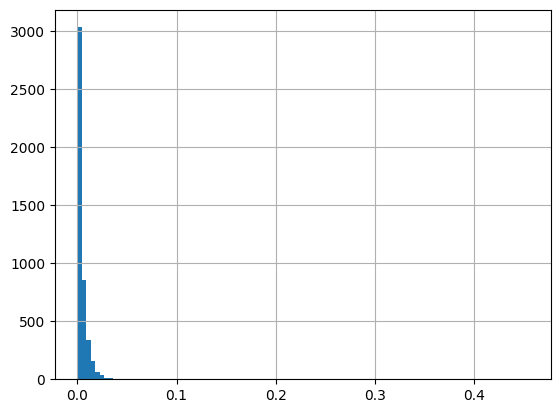

In [26]:
df_adv.daily_ctr.hist(bins=100)

In [27]:
df_adv.daily_ctr.describe()

count    4544.000000
mean        0.005323
std         0.012099
min         0.000000
25%         0.001754
50%         0.003109
75%         0.005800
max         0.454545
Name: daily_ctr, dtype: float64

<Axes: >

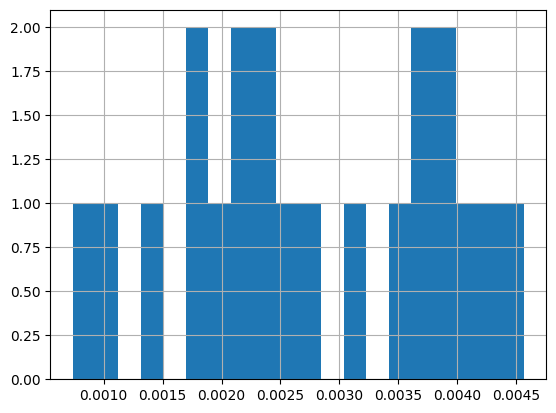

In [28]:
df_adv[df_adv['drug_name']=='Ангиорус '].daily_ctr.hist(bins=20)

In [29]:
df_adv[df_adv['drug_name']=='Ангиорус '].daily_ctr.describe()

count    21.000000
mean      0.002769
std       0.001102
min       0.000740
25%       0.001980
50%       0.002636
75%       0.003731
max       0.004566
Name: daily_ctr, dtype: float64

<Axes: >

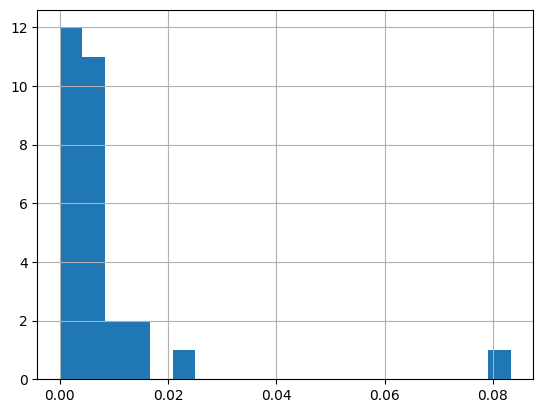

In [30]:
df_adv[df_adv['drug_name']=='Кагоцел, Кипферон '].daily_ctr.hist(bins=20)

In [31]:
df_adv[df_adv['drug_name']=='Кагоцел, Кипферон '].daily_ctr.describe()

count    29.000000
mean      0.008463
std       0.015065
min       0.000000
25%       0.003178
50%       0.004625
75%       0.007440
max       0.083333
Name: daily_ctr, dtype: float64

In [32]:
df_adv.query('daily_ctr==0').drug_name.unique()

array(['Венарус', 'Венарус_гель', 'Венарус, Венапрокт', 'Дексонал',
       'Необутин', 'Максилак', 'Необутин, Максилак', 'Диклофенак-Акос',
       'СВ002', 'Эльмуцин ', 'Акнауцер', 'Кагоцел, Эльмуцин', 'Кагоцел ',
       'Кагоцел, Кипферон ', 'Венарус, Дексонал ', 'Парацитолгин ',
       'Дексонал, Диклофенак-АКОС'], dtype=object)

In [33]:
df_adv.query('daily_ctr==0').drug_name.nunique()

17

In [34]:
df_adv.daily_ctr.min()

0.0

In [35]:
df_adv.daily_ctr.max()

0.45454545454545453

In [36]:
df_adv.query('daily_ctr == daily_ctr.max()')

,platform,campaign_id,campaign_name,date,impressions,clicks,drug_name,auditory,databse,adv_way,month,day,dayofweek,daily_ctr
2358,yandex direct,80603153,Диклофенак-Акос | Фармацевты | Баннеры | База ...,2023-03-04,11,5,Диклофенак-Акос,Фармацевты,Breffi,Баннеры,3,4,5,0.454545


In [37]:
data_80603153 = df_adv[df_adv['campaign_id']==80603153].sort_values(by='date')
data_80603153.shape

(180, 14)

In [38]:
data_80603153.head()

,platform,campaign_id,campaign_name,date,impressions,clicks,drug_name,auditory,databse,adv_way,month,day,dayofweek,daily_ctr
1560,yandex direct,80603153,Диклофенак-Акос | Фармацевты | База Брефи,2022-11-16,12316,34,Диклофенак-Акос,Фармацевты,Breffi,unknown,11,16,2,0.002761
1633,yandex direct,80603153,Диклофенак-Акос | Фармацевты | База Брефи,2022-11-17,40193,81,Диклофенак-Акос,Фармацевты,Breffi,unknown,11,17,3,0.002015
1717,yandex direct,80603153,Диклофенак-Акос | Фармацевты | База Брефи,2022-11-18,4838,11,Диклофенак-Акос,Фармацевты,Breffi,unknown,11,18,4,0.002274
1842,yandex direct,80603153,Диклофенак-Акос | Фармацевты | База Брефи,2022-11-19,17790,46,Диклофенак-Акос,Фармацевты,Breffi,unknown,11,19,5,0.002586
1927,yandex direct,80603153,Диклофенак-Акос | Фармацевты | База Брефи,2022-11-20,16033,46,Диклофенак-Акос,Фармацевты,Breffi,unknown,11,20,6,0.002869


In [39]:
data_80603153['date'].is_monotonic_increasing

True

In [40]:
data_80603153.date.min()

Timestamp('2022-11-16 00:00:00')

In [41]:
data_80603153.date.max()

Timestamp('2023-07-26 00:00:00')

In [42]:
data_80603153.date.max()-data_80603153.date.min()

Timedelta('252 days 00:00:00')

<Axes: xlabel='date', ylabel='daily_ctr'>

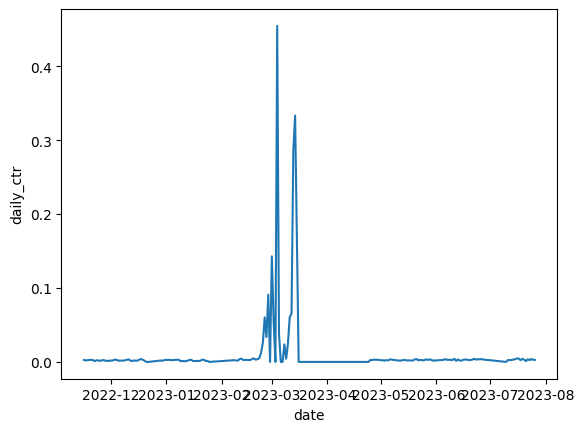

In [43]:
sns.lineplot(data=data_80603153, x="date", y="daily_ctr")

<Axes: xlabel='date', ylabel='impressions'>

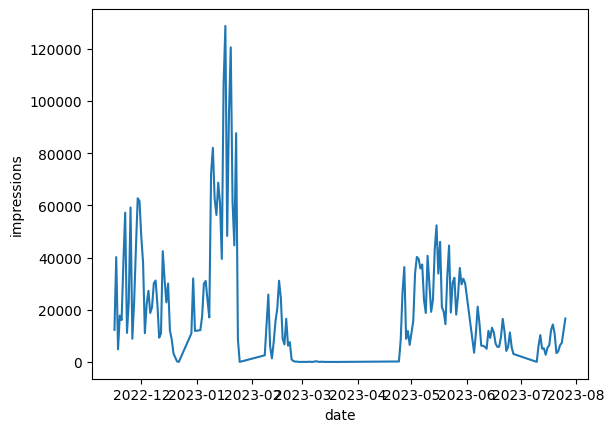

In [44]:
sns.lineplot(data=data_80603153, x="date", y="impressions")

<Axes: xlabel='date', ylabel='clicks'>

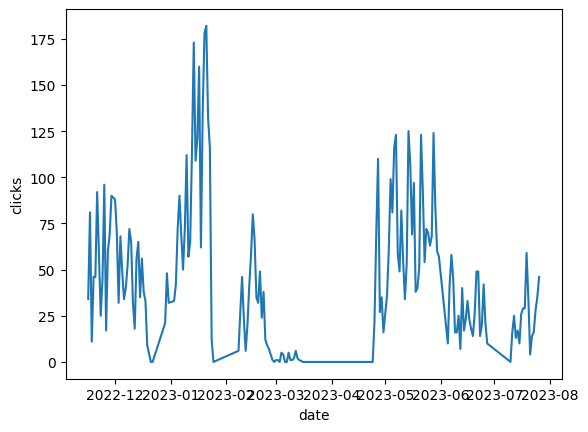

In [45]:
sns.lineplot(data=data_80603153, x="date", y="clicks")

In [46]:
data.query('clicks == clicks.max()')

,platform,campaign_id,campaign_name,date,impressions,clicks,drug_name,auditory,databse,adv_way,month,day,dayofweek
2958,yandex direct,82469257,Дексонал | Фармацевты | Баннеры | База БФГ,2023-05-16,116491,598,Дексонал,Фармацевты,БФГ,Баннеры,5,16,1


In [47]:
data[data['campaign_id']==82469257].date.max()-data[data['campaign_id']==82469257].date.min()

Timedelta('183 days 00:00:00')

<Axes: xlabel='date', ylabel='daily_ctr'>

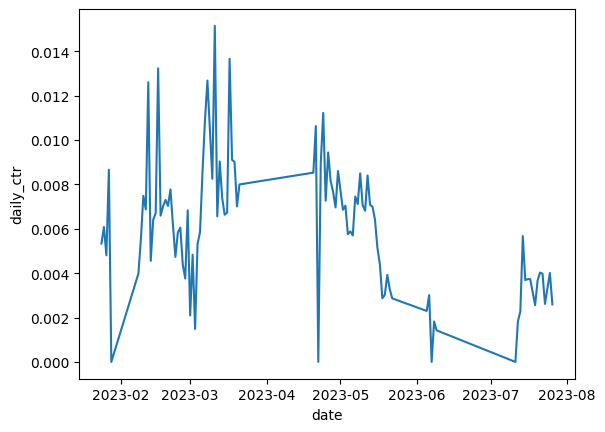

In [48]:
sns.lineplot(data=df_adv[df_adv['campaign_id']==82469257], x="date", y="daily_ctr")

<Axes: xlabel='date', ylabel='impressions'>

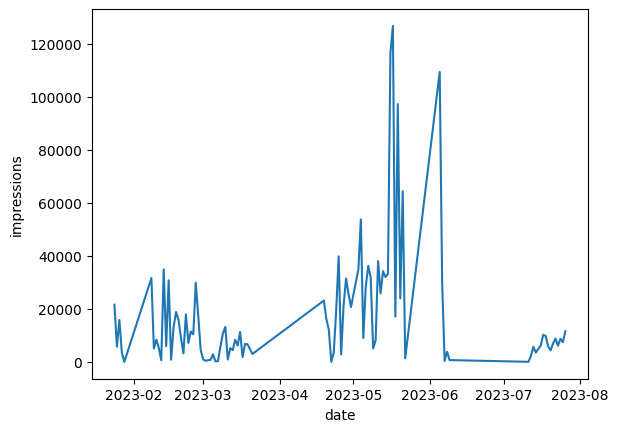

In [49]:
sns.lineplot(data=data[data['campaign_id']==82469257], x="date", y="impressions")

<Axes: xlabel='date', ylabel='clicks'>

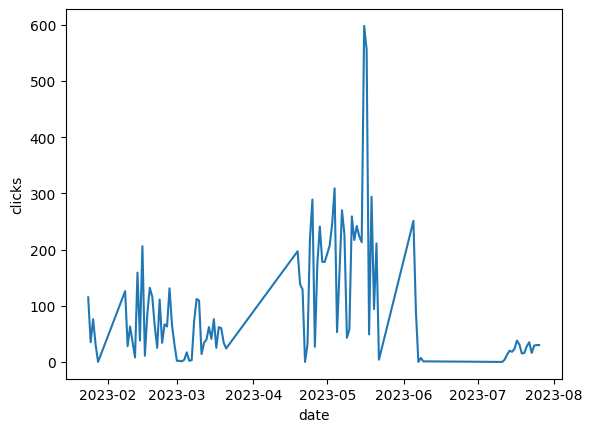

In [50]:
sns.lineplot(data=data[data['campaign_id']==82469257], x="date", y="clicks")

In [51]:
df_adv.query('impressions == impressions.max()')

,platform,campaign_id,campaign_name,date,impressions,clicks,drug_name,auditory,databse,adv_way,month,day,dayofweek,daily_ctr
1085,yandex direct,79820654,Дексонал | Фармацевты | Баннеры | База Брефи,2023-06-05,146516,459,Дексонал,Фармацевты,Breffi,Баннеры,6,5,0,0.003133


In [52]:
df_adv[df_adv['campaign_id']==79820654].date.max()-df_adv[df_adv['campaign_id']==79820654].date.min()

Timedelta('280 days 00:00:00')

<Axes: xlabel='date', ylabel='daily_ctr'>

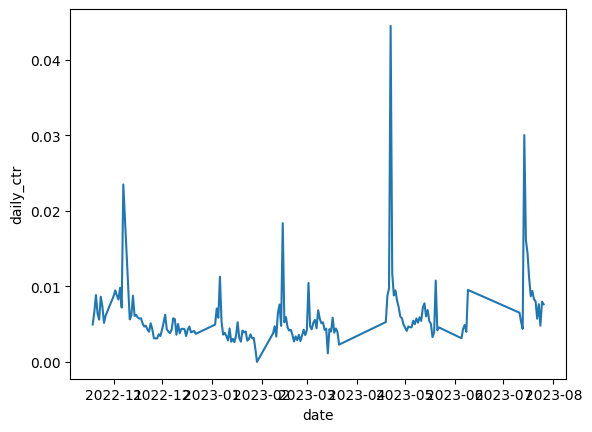

In [53]:
sns.lineplot(data=df_adv[df_adv['campaign_id']==79820654], x="date", y="daily_ctr")

<Axes: xlabel='date', ylabel='impressions'>

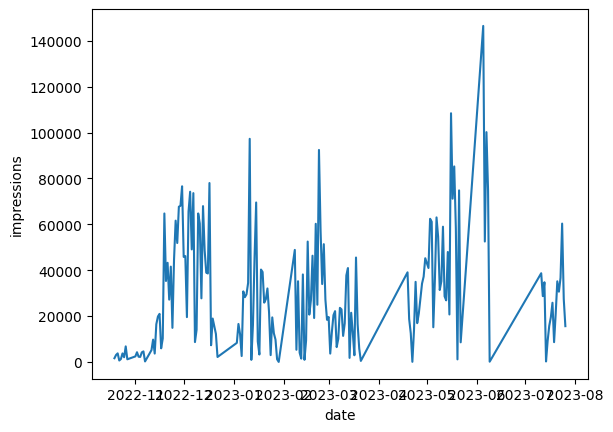

In [54]:
sns.lineplot(data=df_adv[df_adv['campaign_id']==79820654], x="date", y="impressions")

<Axes: xlabel='date', ylabel='clicks'>

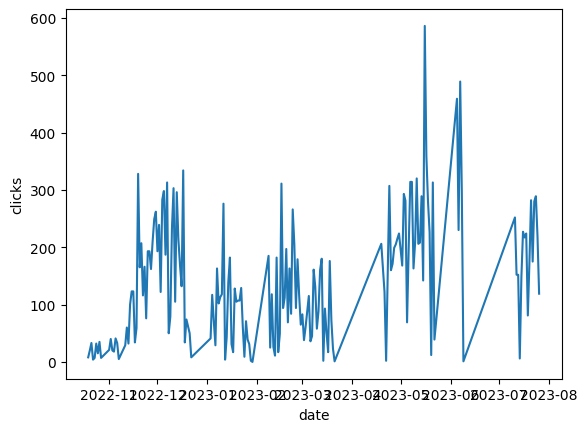

In [55]:
sns.lineplot(data=df_adv[df_adv['campaign_id']==79820654], x="date", y="clicks")

**Примем за успешные значения CTR=3% и более**

In [56]:
df_adv.query('daily_ctr >= 0.03').shape

(50, 14)

In [57]:
df_adv[df_adv['daily_ctr']>=0.03]['campaign_id'].nunique()

21

In [58]:
df_adv[df_adv['daily_ctr']>=0.03]['campaign_id'].unique()

array([79820654, 86809161, 86931353, 87302599, 86931208, 89013407,
       88168171, 87302401, 83579589, 86230785, 84390401, 85031102,
       81660757, 80603153, 82546666, 83579534, 82469114, 82546504,
       81940696, 82542346, 77016802])

In [59]:
df_adv[df_adv['daily_ctr']>=0.03]['drug_name'].unique()

array(['Дексонал', 'Диклофенак-Акос', 'Необутин', 'Венарус, Венапрокт',
       'Эльмуцин ', 'Максилак', 'Кагоцел, Эльмуцин', 'Кагоцел, Кипферон '],
      dtype=object)

In [60]:
print(f"Meдианное значение CTR {round(df_adv.daily_ctr.median()*100, 2)} %")

Meдианное значение CTR 0.31 %


In [61]:
df_adv[df_adv['daily_ctr']>=df_adv.daily_ctr.median()]['campaign_id'].unique()

array([89644586, 90990136, 79820654, 80285056, 89012509, 89012781,
       89012833, 89012878, 90990186, 86809161, 86809100, 91236208,
       91236196, 88167803, 89012714, 82541853, 82469257, 82469114,
       82468420, 89013246, 89013015, 89013088, 91236253, 75993195,
       80603153, 89013147, 89012360, 91236290, 91236472, 91236513,
       91236535, 91236727, 91236737, 89012433, 89012278, 89013791,
       86931353, 89013656, 89013623, 89013504, 89013463, 89013407,
       87092471, 87302706, 86931208, 89013364, 87302681, 88168171,
       77016802, 87302401, 87302599, 87092493, 87249736, 87249614,
       89013759, 89014105, 89014027, 89013988, 83579534, 83579589,
       89014066, 84389757, 84390401, 86807912, 86808141, 86230785,
       77016812, 85031102, 85888407, 85888445, 86230757, 85030998,
       81660757, 82542346, 83851712, 83579719, 83579639, 82542278,
       82320987, 83851999, 82541931, 77767201, 80102700, 82543630,
       82546598, 82546504, 82546666, 82546871, 83534000, 83533

In [62]:
df_adv[df_adv['daily_ctr']>=df_adv.daily_ctr.median()]['campaign_id'].nunique()

106

In [63]:
df_adv[df_adv['daily_ctr']>=df_adv.daily_ctr.median()]['drug_name'].unique()

array(['СВ002', 'Необутин', 'Дексонал', 'Диклофенак-Акос', 'Венарус',
       'Венарус, Венапрокт', 'Венарус_гель', 'Максилак',
       'Необутин, Максилак', 'Эльмуцин ', 'Акнауцер', 'Кагоцел, Эльмуцин',
       'Кагоцел ', 'Кагоцел, Кипферон ', 'Парацитолгин ', 'Ангиорус ',
       'Дексонал, Диклофенак-АКОС'], dtype=object)

In [64]:
df_adv.query('clicks >= 100').sort_values(by='clicks', ascending=False)

,platform,campaign_id,campaign_name,date,impressions,clicks,drug_name,auditory,databse,adv_way,month,day,dayofweek,daily_ctr
2958,yandex direct,82469257,Дексонал | Фармацевты | Баннеры | База БФГ,2023-05-16,116491,598,Дексонал,Фармацевты,БФГ,Баннеры,5,16,1,0.005133
2954,yandex direct,79820654,Дексонал | Фармацевты | Баннеры | База Брефи,2023-05-16,108434,586,Дексонал,Фармацевты,Breffi,Баннеры,5,16,1,0.005404
3038,yandex direct,82469257,Дексонал | Фармацевты | Баннеры | База БФГ,2023-05-17,126681,556,Дексонал,Фармацевты,БФГ,Баннеры,5,17,2,0.004389
1208,yandex direct,79820654,Дексонал | Фармацевты | Баннеры | База Брефи,2023-06-07,100201,489,Дексонал,Фармацевты,Breffi,Баннеры,6,7,2,0.004880
1085,yandex direct,79820654,Дексонал | Фармацевты | Баннеры | База Брефи,2023-06-05,146516,459,Дексонал,Фармацевты,Breffi,Баннеры,6,5,0,0.003133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3187,yandex direct,82468420,Венарус | Фармацевты | Баннеры | База БФГ,2023-05-19,45925,100,Венарус,Фармацевты,БФГ,Баннеры,5,19,4,0.002177
1384,yandex direct,79820654,Дексонал | Фармацевты | База Брефи,2022-11-14,16445,100,Дексонал,Фармацевты,Breffi,unknown,11,14,0,0.006081
4234,yandex direct,75993195,Венарус | Фармацевты | База Брефи,2022-12-12,57047,100,Венарус,Фармацевты,Breffi,unknown,12,12,0,0.001753
3786,yandex direct,75993195,Венарус | Фармацевты | Баннеры | База Брефи,2023-03-19,36621,100,Венарус,Фармацевты,Breffi,Баннеры,3,19,6,0.002731


In [65]:
df_adv[df_adv['clicks']>=100]['campaign_id'].nunique()

14

In [66]:
df_adv[df_adv['clicks']>=100]['campaign_id'].unique()

array([79820654, 86809161, 77016802, 87302706, 75993195, 82469257,
       80603153, 82468420, 83533836, 83534000, 81940696, 81660757,
       76108892, 76194102])

In [67]:
df_adv[df_adv['clicks']>=100]['campaign_name'].unique()

array(['Дексонал | Фармацевты | Баннеры | База Брефи',
       'СВ003 | Диклофенак-Акос | Терапевты | Баннеры | База Breffi',
       'Дексонал | Неврологи',
       'ВА039 | Максилак | Фармацевты | Баннеры | База Breffi',
       'Венарус | Фармацевты | Баннеры | База Брефи',
       'Дексонал | Фармацевты | Баннеры | База БФГ | Навражных',
       'Диклофенак-Акос | Фармацевты | Баннеры | База Брефи',
       'Дексонал | Фармацевты | Баннеры | База БФГ',
       'Венарус | Фармацевты | Баннеры | База БФГ',
       'Диклофенак-Акос | Фармацевты | Баннеры | База БФГ | Навражных',
       'Венарус | Фармацевты | Баннеры | База БФГ | Навражных',
       'Максилак | Педиатры | Баннеры | База БФГ',
       'Максилак | Педиатры | Баннеры | База Брефи',
       'Кагоцел, Кипферон | Педиатры | База Брефи',
       'Кагоцел, Эльмуцин | Терапевты | Баннеры | База Брефи',
       'Дексонал | Фармацевты | База Брефи',
       'Венарус | Фармацевты | База Брефи', 'Ангиорус | Фармацевты | CPC',
       'Дексонал | 

In [68]:
df_adv[df_adv['clicks']>=100]['drug_name'].unique()

array(['Дексонал', 'Диклофенак-Акос', 'Максилак', 'Венарус',
       'Кагоцел, Кипферон ', 'Кагоцел, Эльмуцин', 'Ангиорус ',
       'Дексонал, Диклофенак-АКОС'], dtype=object)

<Axes: >

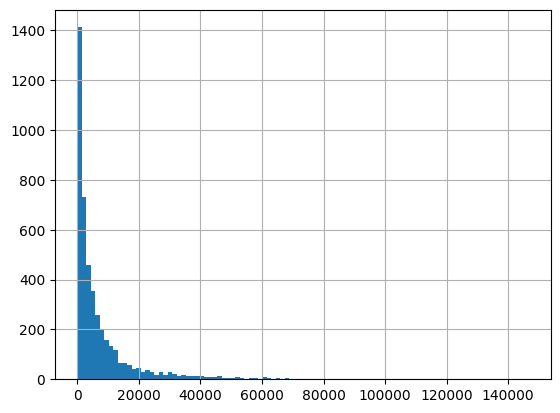

In [69]:
df_adv.impressions.hist(bins=100)

<Axes: >

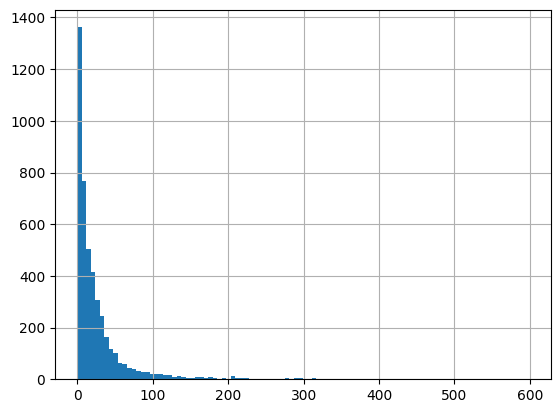

In [70]:
df_adv.clicks.hist(bins=100)

In [71]:
df_adv.describe().T

,count,mean,std,min,25%,50%,75%,max
campaign_id,4544.0,8.293761e+07,4.492887e+06,75218950.0,7.983848e+07,8.254185e+07,8.724961e+07,9.123674e+07
impressions,4544.0,7.950167e+03,1.321695e+04,1.0,1.104000e+03,3.276500e+03,8.736500e+03,1.465160e+05
clicks,4544.0,2.758253e+01,4.680523e+01,0.0,4.000000e+00,1.300000e+01,3.100000e+01,5.980000e+02
month,4544.0,5.660871e+00,3.003058e+00,1.0,3.000000e+00,6.000000e+00,7.000000e+00,1.200000e+01
day,4544.0,1.639217e+01,7.491828e+00,1.0,1.100000e+01,1.600000e+01,2.300000e+01,3.100000e+01
dayofweek,4544.0,2.940361e+00,1.976910e+00,0.0,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00
daily_ctr,4544.0,5.322751e-03,1.209894e-02,0.0,1.754349e-03,3.109345e-03,5.800039e-03,4.545455e-01


In [74]:
df_adv.columns

Index(['platform', 'campaign_id', 'campaign_name', 'date', 'impressions',
       'clicks', 'drug_name', 'auditory', 'databse', 'adv_way', 'month', 'day',
       'dayofweek', 'daily_ctr'],
      dtype='object')

Посторим две модели:
1. модель для предсказания количества показов рекламы
2. модель для предсказания CTR

Метрика RMSE

In [75]:
X = df_adv.drop(columns=['platform', 'campaign_id', 'campaign_name', 'daily_ctr', 'date', 'impressions', 'clicks'], axis=1)
y = df_adv.impressions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
display(X_train.shape)
y_train.shape

(3635, 7)

(3635,)

In [77]:
onehot_encoder = OneHotEncoder(sparse=False, drop='first')

In [78]:
categorical_col = ['drug_name', 'auditory', 'databse', 'adv_way']
numerical_col = ['month', 'day', 'dayofweek']

In [79]:
onehot_encoder.fit(X_train[categorical_col])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(drop='first', sparse=False, sparse_output=False)

In [80]:
train_ohe = onehot_encoder.transform(X_train[categorical_col])

In [81]:
train_ohe = pd.DataFrame(train_ohe, columns=onehot_encoder.get_feature_names_out(categorical_col),\
                                                                        index=X_train.index)
features_train_ohe = train_ohe.join(X_train[numerical_col])
features_train_ohe.head()

,drug_name_Ангиорус,drug_name_Венарус,"drug_name_Венарус, Венапрокт","drug_name_Венарус, Дексонал",drug_name_Венарус_гель,drug_name_Дексонал,"drug_name_Дексонал, Диклофенак-АКОС",drug_name_Диклофенак-Акос,drug_name_Кагоцел,"drug_name_Кагоцел, Кипферон",...,adv_way_Баннер на памятку,adv_way_Баннеры,adv_way_Баннеры,adv_way_Баннеры gif,adv_way_Видео,adv_way_Видеобаннер,adv_way_Доп видео,month,day,dayofweek
1726,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6,13,1
2770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,8,2
1745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,25,5
2440,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,19,4
3818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,27,5


In [82]:
features_train_ohe.shape

(3635, 39)

In [83]:
test_ohe = onehot_encoder.transform(X_test[categorical_col])

In [84]:
test_ohe = pd.DataFrame(test_ohe, columns=onehot_encoder.get_feature_names_out(categorical_col),\
                                                                        index=X_test.index)
features_test_ohe = test_ohe.join(X_test[numerical_col])
features_test_ohe.head()

,drug_name_Ангиорус,drug_name_Венарус,"drug_name_Венарус, Венапрокт","drug_name_Венарус, Дексонал",drug_name_Венарус_гель,drug_name_Дексонал,"drug_name_Дексонал, Диклофенак-АКОС",drug_name_Диклофенак-Акос,drug_name_Кагоцел,"drug_name_Кагоцел, Кипферон",...,adv_way_Баннер на памятку,adv_way_Баннеры,adv_way_Баннеры,adv_way_Баннеры gif,adv_way_Видео,adv_way_Видеобаннер,adv_way_Доп видео,month,day,dayofweek
2124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,18,6
2732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,5,1
698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,29,5
578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,15,0
545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6,24,5


In [85]:
features_train_ohe.columns == features_test_ohe.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [86]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[numerical_col])

StandardScaler()

In [87]:
features_train_ohe[numerical_col] = scaler.transform(features_train_ohe[numerical_col])
features_test_ohe[numerical_col] = scaler.transform(features_test_ohe[numerical_col])

In [88]:
print('Размер тренировочной выборки:', features_train_ohe.shape)
print('Размер тестовой выборки:', features_test_ohe.shape)

Размер тренировочной выборки: (3635, 39)
Размер тестовой выборки: (909, 39)


In [89]:
model_lr = LinearRegression()

scores = cross_validate(
    model_lr, features_train_ohe, y_train, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True
)
print(scores)

{'fit_time': array([0.01512194, 0.00724459, 0.01462626, 0.01331925, 0.0130012 ]), 'score_time': array([0.00317287, 0.0066185 , 0.00682282, 0.00502586, 0.0055511 ]), 'test_score': array([-10285.85987108,  -9945.14303879, -12903.74573632,  -9387.18115502,
       -11085.11654466]), 'train_score': array([-10818.21966259, -10886.91538613, -10088.6274583 , -11008.32386134,
       -10614.65229747])}


In [90]:
print('Среднее значение RMSE для линейной регрессии:', -1*scores['test_score'].mean())

Среднее значение RMSE для линейной регрессии: 10721.409269172995


In [101]:
model_sgd = SGDRegressor(random_state=12345)

grid = {
    "loss" : ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ['l2', 'l1', 'elasticnet', None]
}


sgd = GridSearchCV(
    estimator=model_sgd, param_grid = grid, cv = 5, n_jobs=-1, scoring='neg_root_mean_squared_error'
)

sgd.fit(features_train_ohe, y_train)

GridSearchCV(cv=5, estimator=SGDRegressor(random_state=12345), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['huber', 'epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'penalty': ['l2', 'l1', 'elasticnet', None]},
             scoring='neg_root_mean_squared_error')

In [102]:
print("Best RMSE:", -sgd.best_score_)

Best RMSE: 10797.648771115699


In [103]:
model_rfr = RandomForestRegressor(random_state=12345)


grid_rfr = {
    "n_estimators" : [100, 500, 1000, 1500],
    "max_depth" : [None, 3, 4, 5]
}


rfr = GridSearchCV(
    estimator=model_rfr, param_grid = grid_rfr, cv = 5, n_jobs=-1, scoring='neg_root_mean_squared_error'
)

rfr.fit(features_train_ohe, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5],
                         'n_estimators': [100, 500, 1000, 1500]},
             scoring='neg_root_mean_squared_error')

In [104]:
print("Best RMSE:", -rfr.best_score_)

Best RMSE: 8844.60120499534


In [105]:
ridge = Ridge(random_state=12345)
grid_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search_ridge = GridSearchCV(ridge, grid_ridge, cv=5, scoring='neg_root_mean_squared_error')
grid_search_ridge.fit(features_train_ohe, y_train)

GridSearchCV(cv=5, estimator=Ridge(random_state=12345),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_root_mean_squared_error')

In [106]:
print("Best RMSE:", -grid_search_ridge.best_score_)

Best RMSE: 10718.158198278345


In [107]:
print("Среднее количество показов в день в тестовой выборке:", y_test.mean())

Среднее количество показов в день в тестовой выборке: 8590.7799779978


In [108]:
pred_median = np.ones(y_test.shape) * y_test.median()
print("RMSE для оценки константой:", mean_squared_error(y_test, pred_median)**0.5)

RMSE для оценки константой: 15548.459012817551


In [109]:
dummy_regr = DummyRegressor(strategy="mean") # предсказывает среднее значение тестовой выборки

dummy_regr.fit(features_train_ohe, y_train)
dummy_pred = dummy_regr.predict(features_test_ohe)

print("RMSE для оценки с помощью DummyRegressor:", mean_squared_error(y_test, dummy_pred)**0.5)

RMSE для оценки с помощью DummyRegressor: 14668.34040557955


In [110]:
model_impressions = rfr.best_estimator_

In [111]:
test_pred = model_impressions.predict(features_test_ohe)

print("RMSE RandomForestRegressor() на тестовой выборке:", mean_squared_error(y_test, test_pred)**0.5)

RMSE RandomForestRegressor() на тестовой выборке: 8853.36741149814


In [112]:
rfr.best_params_

{'max_depth': None, 'n_estimators': 1500}

### **Прогноз CTR**

In [113]:
X_ctr = df_adv.drop(columns=['platform', 'campaign_id', 'campaign_name', 'daily_ctr', 'date', 'clicks'], axis=1)
y_ctr = df_adv.daily_ctr

X_train_ctr, X_test_ctr, y_train_ctr, y_test_ctr = train_test_split(X_ctr, y_ctr, test_size=0.2, random_state=42)

In [114]:
numerical_col_ctr = ['month', 'day', 'dayofweek', 'impressions']
onehot_encoder = OneHotEncoder(sparse=False, drop='first')
onehot_encoder.fit(X_train_ctr[categorical_col])

train_ohe_ctr = onehot_encoder.transform(X_train_ctr[categorical_col])
train_ohe_ctr = pd.DataFrame(train_ohe_ctr, columns=onehot_encoder.get_feature_names_out(categorical_col),\
                                                                        index=X_train_ctr.index)
features_train_ohe_ctr = train_ohe_ctr.join(X_train_ctr[numerical_col_ctr])
display(features_train_ohe_ctr.head())


test_ohe_ctr = onehot_encoder.transform(X_test_ctr[categorical_col])
test_ohe_ctr = pd.DataFrame(test_ohe_ctr, columns=onehot_encoder.get_feature_names_out(categorical_col),\
                                                                        index=X_test_ctr.index)
features_test_ohe_ctr = test_ohe_ctr.join(X_test_ctr[numerical_col_ctr])
features_test_ohe_ctr.head()



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,drug_name_Ангиорус,drug_name_Венарус,"drug_name_Венарус, Венапрокт","drug_name_Венарус, Дексонал",drug_name_Венарус_гель,drug_name_Дексонал,"drug_name_Дексонал, Диклофенак-АКОС",drug_name_Диклофенак-Акос,drug_name_Кагоцел,"drug_name_Кагоцел, Кипферон",...,adv_way_Баннеры,adv_way_Баннеры,adv_way_Баннеры gif,adv_way_Видео,adv_way_Видеобаннер,adv_way_Доп видео,month,day,dayofweek,impressions
1726,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,6,13,1,2309
2770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,3,8,2,642
1745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2,25,5,12666
2440,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8,19,4,1583
3818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,5,27,5,8416


,drug_name_Ангиорус,drug_name_Венарус,"drug_name_Венарус, Венапрокт","drug_name_Венарус, Дексонал",drug_name_Венарус_гель,drug_name_Дексонал,"drug_name_Дексонал, Диклофенак-АКОС",drug_name_Диклофенак-Акос,drug_name_Кагоцел,"drug_name_Кагоцел, Кипферон",...,adv_way_Баннеры,adv_way_Баннеры,adv_way_Баннеры gif,adv_way_Видео,adv_way_Видеобаннер,adv_way_Доп видео,month,day,dayofweek,impressions
2124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,6,18,6,45
2732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7,5,1,12281
698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,4,29,5,1135
578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,5,15,0,2902
545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,6,24,5,7499


In [115]:
scaler = StandardScaler()
scaler.fit(features_test_ohe_ctr[numerical_col_ctr])

StandardScaler()

In [116]:
features_train_ohe_ctr[numerical_col_ctr] = scaler.transform(features_train_ohe_ctr[numerical_col_ctr])
features_test_ohe_ctr[numerical_col_ctr] = scaler.transform(features_test_ohe_ctr[numerical_col_ctr])

In [117]:
features_test_ohe_ctr.head()

,drug_name_Ангиорус,drug_name_Венарус,"drug_name_Венарус, Венапрокт","drug_name_Венарус, Дексонал",drug_name_Венарус_гель,drug_name_Дексонал,"drug_name_Дексонал, Диклофенак-АКОС",drug_name_Диклофенак-Акос,drug_name_Кагоцел,"drug_name_Кагоцел, Кипферон",...,adv_way_Баннеры,adv_way_Баннеры,adv_way_Баннеры gif,adv_way_Видео,adv_way_Видеобаннер,adv_way_Доп видео,month,day,dayofweek,impressions
2124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.051004,0.234635,1.597681,-0.583471
2732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.391909,-1.535918,-0.949306,0.251953
698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.630805,1.732796,1.088283,-0.509050
578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,-0.289900,-0.173954,-1.458703,-0.388406
545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.051004,1.051814,1.088283,-0.074542


In [131]:
model_rfr_ctr = RandomForestRegressor(random_state=12345)


grid_rfr_ctr = {
    "criterion" : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
}


rfr_ctr = GridSearchCV(
    estimator=model_rfr_ctr, param_grid = grid_rfr_ctr, cv = 5, n_jobs=-1, scoring='neg_root_mean_squared_error'
)

rfr_ctr.fit(features_train_ohe_ctr, y_train_ctr)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse', 'poisson']},
             scoring='neg_root_mean_squared_error')

In [132]:
print("Best RMSE:", -rfr_ctr.best_score_)

Best RMSE: 0.011253222809573379


In [133]:
hgbr = HistGradientBoostingRegressor(random_state=12345)
hgbr_grid_ctr = {'loss': ['squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile']}

grid_search_hgbr_ctr = GridSearchCV(hgbr, hgbr_grid_ctr, cv=5, scoring='neg_root_mean_squared_error')
grid_search_hgbr_ctr.fit(features_train_ohe_ctr, y_train_ctr)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 372, in fit
    y = self._encode_y(y)
  File "/usr/local/lib/p

GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(random_state=12345),
             param_grid={'loss': ['squared_error', 'absolute_error', 'gamma',
                                  'poisson', 'quantile']},
             scoring='neg_root_mean_squared_error')

In [134]:
print("Best RMSE:", -grid_search_hgbr_ctr.best_score_)

Best RMSE: 0.011188107660432902


In [135]:
model_lr_ctr = LinearRegression()

scores_ctr = cross_validate(
    model_lr_ctr, features_train_ohe_ctr, y_train_ctr, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True
)
print(scores_ctr)

{'fit_time': array([0.01306343, 0.0067637 , 0.00656939, 0.00674033, 0.00675344]), 'score_time': array([0.00322294, 0.00272393, 0.00453496, 0.00264668, 0.00262594]), 'test_score': array([-0.01647886, -0.0178013 , -0.00912602, -0.00794659, -0.00531802]), 'train_score': array([-0.01097029, -0.01043981, -0.01292769, -0.01312522, -0.01345499])}


In [136]:
print('Среднее значение RMSE для линейной регрессии:', -1*scores_ctr['test_score'].mean())

Среднее значение RMSE для линейной регрессии: 0.011334157291513937


In [138]:
model_ctr = grid_search_hgbr_ctr.best_estimator_
test_pred = model_ctr.predict(features_test_ohe_ctr)

print("RMSE HistGradientBoostingRegressor() на тестовой выборке:", mean_squared_error(y_test_ctr, test_pred)**0.5)

RMSE HistGradientBoostingRegressor() на тестовой выборке: 0.007542784849381493


**Предсказание ctr на основе предсказания impressions**

In [139]:
df_adv[df_adv['drug_name']=='Кагоцел ']['campaign_id'].nunique()

3

In [140]:
df_adv[df_adv['drug_name']=='Кагоцел ']['campaign_id'].unique()

array([79838478, 82468627, 79838314])

In [141]:
final_test = df_adv[df_adv['campaign_id']==82468627]

In [142]:
final_test.shape

(45, 14)

In [143]:
final_test = final_test.sort_values(by='date', ascending=True)

In [144]:
final_test.head(14)

,platform,campaign_id,campaign_name,date,impressions,clicks,drug_name,auditory,databse,adv_way,month,day,dayofweek,daily_ctr
3442,yandex direct,82468627,Кагоцел | Фармацевты | Баннеры | База БФГ,2023-01-24,3470,11,Кагоцел,Фармацевты,БФГ,Баннеры,1,24,1,0.003170
3529,yandex direct,82468627,Кагоцел | Фармацевты | Баннеры | База БФГ,2023-01-25,17138,21,Кагоцел,Фармацевты,БФГ,Баннеры,1,25,2,0.001225
3591,yandex direct,82468627,Кагоцел | Фармацевты | Баннеры | База БФГ,2023-01-26,6122,18,Кагоцел,Фармацевты,БФГ,Баннеры,1,26,3,0.002940
3678,yandex direct,82468627,Кагоцел | Фармацевты | Баннеры | База БФГ,2023-01-27,1520,4,Кагоцел,Фармацевты,БФГ,Баннеры,1,27,4,0.002632
3760,yandex direct,82468627,Кагоцел | Фармацевты | Баннеры | База БФГ,2023-01-28,51,0,Кагоцел,Фармацевты,БФГ,Баннеры,1,28,5,0.000000
3917,yandex direct,82468627,Кагоцел | Фармацевты | Баннеры | База БФГ,2023-02-08,15432,28,Кагоцел,Фармацевты,БФГ,Баннеры,2,8,2,0.001814
4004,yandex direct,82468627,Кагоцел | Фармацевты | Баннеры | База БФГ,2023-02-09,13900,13,Кагоцел,Фармацевты,БФГ,Баннеры,2,9,3,0.000935
4089,yandex direct,82468627,Кагоцел | Фармацевты | Баннеры | База БФГ,2023-02-10,11153,17,Кагоцел,Фармацевты,БФГ,Баннеры,2,10,4,0.001524
4161,yandex direct,82468627,Кагоцел | Фармацевты | Баннеры | База БФГ,2023-02-11,2004,5,Кагоцел,Фармацевты,БФГ,Баннеры,2,11,5,0.002495
4223,yandex direct,82468627,Кагоцел | Фармацевты | Баннеры | База БФГ,2023-02-12,478,0,Кагоцел,Фармацевты,БФГ,Баннеры,2,12,6,0.000000


In [145]:
final_test.head(14).describe().T

,count,mean,std,min,25%,50%,75%,max
campaign_id,14.0,8.246863e+07,0.000000,82468627.0,8.246863e+07,8.246863e+07,8.246863e+07,8.246863e+07
impressions,14.0,8.568929e+03,6077.530514,51.0,2.370500e+03,1.047850e+04,1.365400e+04,1.713800e+04
clicks,14.0,1.607143e+01,10.809286,0.0,6.500000e+00,1.750000e+01,2.625000e+01,3.000000e+01
month,14.0,1.642857e+00,0.497245,1.0,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
day,14.0,1.700000e+01,7.337994,8.0,1.125000e+01,1.450000e+01,2.475000e+01,2.800000e+01
dayofweek,14.0,2.928571e+00,1.730464,0.0,2.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00
daily_ctr,14.0,1.829484e-03,0.000990,0.0,1.300074e-03,2.138379e-03,2.479275e-03,3.170029e-03


In [146]:
X_final_test_ctr = final_test.drop(columns=['platform', 'campaign_id', 'campaign_name', 'daily_ctr', 'date', 'clicks'], axis=1)
y_final_test_impressions = final_test.impressions
y_final_test_ctr = final_test.daily_ctr

In [147]:
final_test_ohe_ctr = onehot_encoder.transform(X_final_test_ctr[categorical_col])
final_test_ohe_ctr = pd.DataFrame(final_test_ohe_ctr, columns=onehot_encoder.get_feature_names_out(categorical_col),\
                                                                        index=X_final_test_ctr.index)
features_final_test_ohe_ctr = final_test_ohe_ctr.join(X_final_test_ctr[numerical_col_ctr])
features_final_test_ohe_imp = features_final_test_ohe_ctr.drop(columns=['impressions'], axis=1)
features_final_test_ohe_ctr.head()

,drug_name_Ангиорус,drug_name_Венарус,"drug_name_Венарус, Венапрокт","drug_name_Венарус, Дексонал",drug_name_Венарус_гель,drug_name_Дексонал,"drug_name_Дексонал, Диклофенак-АКОС",drug_name_Диклофенак-Акос,drug_name_Кагоцел,"drug_name_Кагоцел, Кипферон",...,adv_way_Баннеры,adv_way_Баннеры,adv_way_Баннеры gif,adv_way_Видео,adv_way_Видеобаннер,adv_way_Доп видео,month,day,dayofweek,impressions
3442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,24,1,3470
3529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,25,2,17138
3591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,26,3,6122
3678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,27,4,1520
3760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,28,5,51


In [148]:
features_final_test_ohe_imp.shape

(45, 39)

In [149]:
features_final_test_ohe_ctr[numerical_col_ctr] = scaler.transform(features_final_test_ohe_ctr[numerical_col_ctr])

In [150]:
features_final_test_ohe_impressions = features_final_test_ohe_ctr.drop(columns=['impressions'], axis=1)

In [151]:
final_test_impressions_pred= model_impressions.predict(features_final_test_ohe_impressions)

print("RMSE RandomForestRegressor() на финальном тесте:", mean_squared_error(y_final_test_impressions, final_test_impressions_pred)**0.5)

RMSE RandomForestRegressor() на финальном тесте: 1704.1912046805655


In [152]:
test_pred_impressions = pd.concat(
    [features_final_test_ohe_imp.reset_index(), pd.DataFrame(final_test_impressions_pred, columns=['impressions'])],
    axis=1
)

In [153]:
test_pred_impressions.head()

,index,drug_name_Ангиорус,drug_name_Венарус,"drug_name_Венарус, Венапрокт","drug_name_Венарус, Дексонал",drug_name_Венарус_гель,drug_name_Дексонал,"drug_name_Дексонал, Диклофенак-АКОС",drug_name_Диклофенак-Акос,drug_name_Кагоцел,...,adv_way_Баннеры,adv_way_Баннеры,adv_way_Баннеры gif,adv_way_Видео,adv_way_Видеобаннер,adv_way_Доп видео,month,day,dayofweek,impressions
0,3442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,24,1,5902.639333
1,3529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,25,2,13238.529333
2,3591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,26,3,7968.556000
3,3678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,27,4,7068.923333
4,3760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,28,5,2038.740000


In [154]:
test_pred_impressions=test_pred_impressions.drop(columns=['index'], axis=1)

In [155]:
test_pred_impressions[numerical_col_ctr] = scaler.transform(test_pred_impressions[numerical_col_ctr])

In [156]:
test_pred_impressions.head()

,drug_name_Ангиорус,drug_name_Венарус,"drug_name_Венарус, Венапрокт","drug_name_Венарус, Дексонал",drug_name_Венарус_гель,drug_name_Дексонал,"drug_name_Дексонал, Диклофенак-АКОС",drug_name_Диклофенак-Акос,drug_name_Кагоцел,"drug_name_Кагоцел, Кипферон",...,adv_way_Баннеры,adv_way_Баннеры,adv_way_Баннеры gif,adv_way_Видео,adv_way_Видеобаннер,adv_way_Доп видео,month,day,dayofweek,impressions
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-1.653518,1.051814,-0.949306,-0.183535
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-1.653518,1.188010,-0.439909,0.317329
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-1.653518,1.324206,0.069489,-0.042483
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-1.653518,1.460403,0.578886,-0.103906
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-1.653518,1.596599,1.088283,-0.447346


In [168]:
final_test_ctr_pred = model_ctr.predict(test_pred_impressions)

print("RMSE HistGradientBoostingRegressor() на финальном тесте:", mean_squared_error(y_final_test_ctr, final_test_ctr_pred)**0.5)

RMSE HistGradientBoostingRegressor() на финальном тесте: 0.0007665977488722207


In [158]:
result_pred = final_test[['date', 'impressions', 'daily_ctr']]
result_pred = result_pred.reset_index(drop=True)

In [160]:
prediction_result = pd.concat(
    [result_pred, pd.DataFrame(final_test_ctr_pred, columns=['predicted_ctr'], index=result_pred.index)], axis=1
)

In [161]:
prediction_result = pd.concat(
    [prediction_result, pd.DataFrame(final_test_impressions_pred, columns=['predicted_impressions'], index=prediction_result.index)], axis=1
)
prediction_result = prediction_result[['date', 'impressions', 'predicted_impressions', 'daily_ctr', 'predicted_ctr']]

In [162]:
prediction_result = prediction_result.set_index('date')
prediction_result.head()

,impressions,predicted_impressions,daily_ctr,predicted_ctr
date,,,,
2023-01-24,3470,5902.639333,0.003170,0.002409
2023-01-25,17138,13238.529333,0.001225,0.002088
2023-01-26,6122,7968.556000,0.002940,0.001999
2023-01-27,1520,7068.923333,0.002632,0.001921
2023-01-28,51,2038.740000,0.000000,0.002682


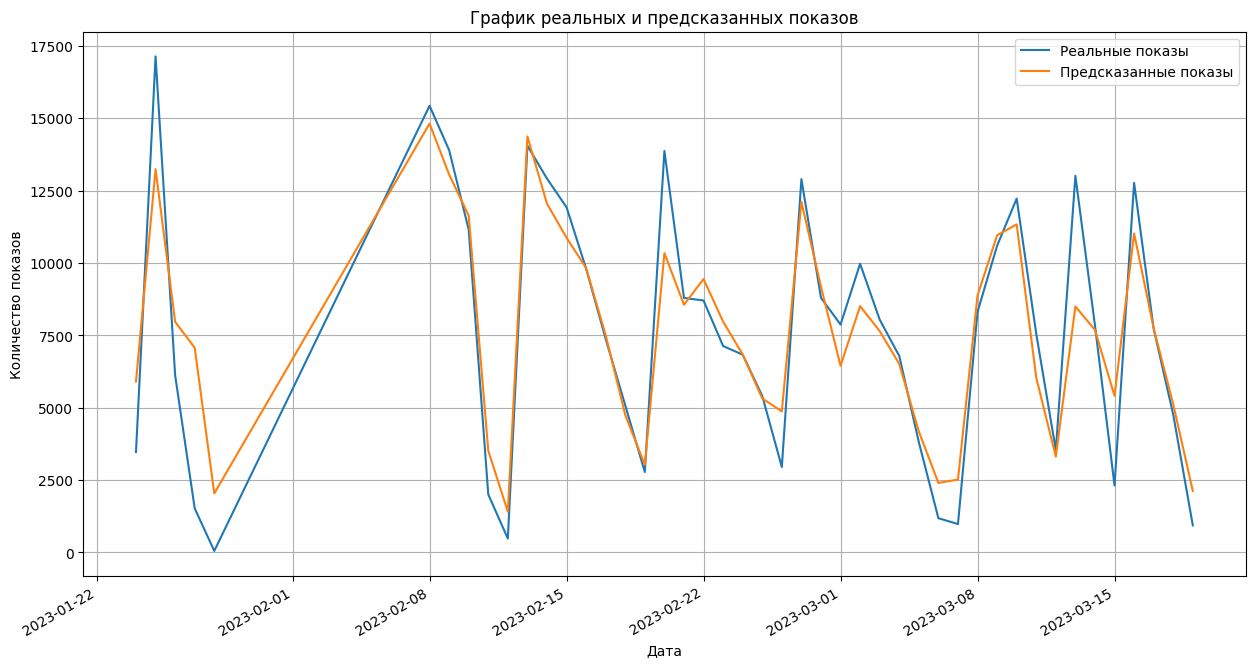

In [163]:
plt.figure(figsize=(15, 8))
prediction_result[['impressions', 'predicted_impressions']].plot(ax=plt.gca(), grid=True)
plt.title('График реальных и предсказанных показов')
plt.xlabel('Дата')
plt.ylabel('Количество показов')
plt.legend(['Реальные показы', 'Предсказанные показы'])
plt.show()

In [164]:
prediction_result['daily_ctr']= prediction_result['daily_ctr']*100
prediction_result['predicted_ctr']= prediction_result['predicted_ctr']*100

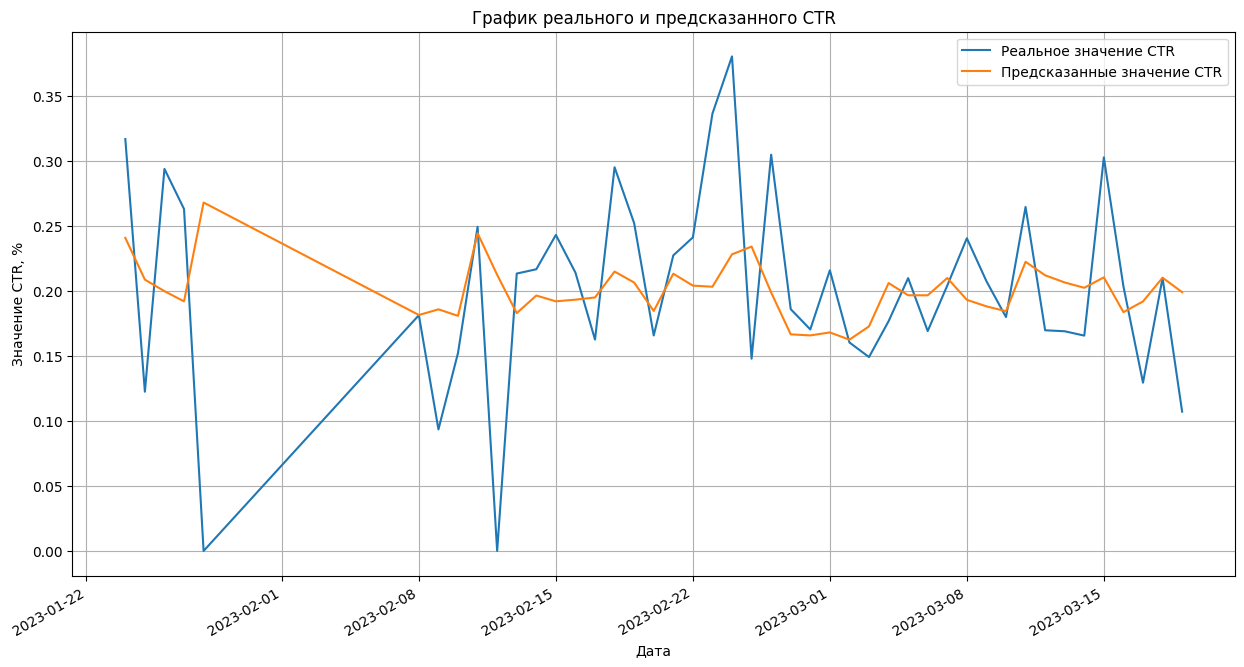

In [166]:
plt.figure(figsize=(15, 8))
prediction_result[['daily_ctr', 'predicted_ctr']].plot(ax=plt.gca(), grid=True)
plt.title('График реального и предсказанного CTR')
plt.xlabel('Дата')
plt.ylabel('Значение CTR, %')
plt.legend(['Реальное значение CTR', 'Предсказанные значение CTR'])
plt.show()